# 2024 CITS4012 Project

# ReadMme

# 1. Dataset Processing

## Importing Libraries

In [1]:
import re
import json
import nltk
import time
import math
import spacy
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gensim.downloader as api
import matplotlib.pyplot as plt

## Loading Datasets

In [2]:
# Load the training data
# with open('/content/drive/MyDrive/data/train.json', 'r') as file:
with open('train.json', 'r') as file:
    data = json.load(file)
    train_data = pd.DataFrame(data['data'], columns=data['columns'])

# Load the test data
# with open('/content/drive/MyDrive/data/test.json', 'r') as file:
with open('test.json', 'r') as file:
    data = json.load(file)
    test_data = pd.DataFrame(data['data'], columns=data['columns'])

# Load the validation data
# with open('/content/drive/MyDrive/data/val.json', 'r') as file:
with open('val.json', 'r') as file:
    data = json.load(file)
    val_data = pd.DataFrame(data['data'], columns=data['columns'])

# Get the x and y lists for training data and test data
training_x = train_data['sentence'].tolist() + val_data['sentence'].tolist()
training_a = train_data['aspect'].tolist() + val_data['aspect'].tolist()
training_y = train_data['polarity'].tolist() + val_data['polarity'].tolist()
test_x = test_data['sentence'].tolist()
test_a = test_data['aspect'].tolist()
test_y = test_data['polarity'].tolist()

## Dataset Analysis

In [3]:
# Size of datasets
print("Training data size :", len(training_x))
print("Test data size     :", len(test_x))

# Aspect Distribution
aspect_distribution = train_data['aspect'].value_counts()
print("\nAspect Distribution:")
print(aspect_distribution.to_string(header=False))

# Sentiment Distribution
sentiment_distribution = train_data['polarity'].value_counts()
print("\nSentiment Distribution:")
print(sentiment_distribution.to_string(header=False))

# Aspect-Sentiment Pair Distribution
aspect_polarity_pair = [(a, p) for a, p in zip(train_data['aspect'], train_data['polarity'])]
aspect_polarity_freq = pd.Series(aspect_polarity_pair).value_counts()
print("\nAspect-Sentiment Pair Distribution:")
print(aspect_polarity_freq.to_string(header=False))

Training data size : 7978
Test data size     : 901

Aspect Distribution:
food             2307
staff            1383
miscellaneous     954
place             694
service           631
menu              475
ambience          324
price             322

Sentiment Distribution:
neutral     3077
negative    2084
positive    1929

Aspect-Sentiment Pair Distribution:
(food, neutral)              1298
(staff, negative)             922
(food, positive)              754
(miscellaneous, neutral)      531
(place, neutral)              430
(menu, neutral)               372
(staff, positive)             332
(service, negative)           329
(food, negative)              255
(miscellaneous, positive)     227
(miscellaneous, negative)     196
(ambience, positive)          181
(service, positive)           174
(place, negative)             139
(price, neutral)              136
(staff, neutral)              129
(service, neutral)            128
(place, positive)             125
(price, negative)         

## Data Preprocessing

In [4]:
! python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.1/12.8 MB 656.4 kB/s eta 0:00:20
      --------------------------------------- 0.3/12.8 MB 2.2 MB/s eta 0:00:06
     - -------------------------------------- 0.5/12.8 MB 3.1 MB/s eta 0:00:05
     -- ------------------------------------- 0.8/12.8 MB 3.7 MB/s eta 0:00:04
     --- ------------------------------------ 1.0/12.8 MB 3.7 MB/s eta 0:00:04
     ---- ----------------------------------- 1.3/12.8 MB 4.2 MB/s eta 0:00:03
     ---- ----------------------------------- 1.5/12.8 MB 4.3 MB/s eta 0:00:03
     ----- ---------------------------------- 1.8/12.8 MB 4.5 MB/s eta 0:00:03
     ------ --------------------------------- 2.1/12.8 MB 4.6 MB/s eta 0:00:03
     ------- -------------------------------- 2.4/12.8 MB 4.8 MB/s eta 0:00:03
     -------- ------------------------------- 2.6/12.8 MB 4.8 MB/

In [5]:
# Punctuation Removal
def remove_punctuation_re(x):
    x = re.sub(r'[^\w\s]', '', x)
    return x

nltk.download('punkt')

# Stopwords Removal
nlp = spacy.load("en_core_web_sm")

def remove_stopwords(x):
    doc = nlp(x)
    x = [word.text for word in doc if not word.is_stop]
    return x

# Stemming
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stem(x):
    x = [stemmer.stem(word) for word in x]
    return x

# Lemmatisation
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize(x):
    x = [lemmatizer.lemmatize(word) for word in x]
    return x

# English Contractions Dictionary
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

# Emoticons
EMOTICONS = r"""
    (?:
      [<>]?
      [:;=8]                     # eyes
      [\-o\*\']?                 # optional nose
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      |
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      [\-o\*\']?                 # optional nose
      [:;=8]                     # eyes
      [<>]?
      |
      <3                         # heart
    )"""

EMOTICON_RE = re.compile(EMOTICONS, re.VERBOSE | re.I | re.UNICODE)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\allis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\allis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
# Function to preprocess the data
def preprocess_data(sentence_list):
    output_list = []
    for sentence in sentence_list:
        emoticons = EMOTICON_RE.findall(sentence)       # Extract emoticons
        sentence = EMOTICON_RE.sub('', sentence)        # Remove emoticons
        sentence = sentence.lower()                     # Case folding
        for word, new_word in contraction_dict.items(): # Deal with contractions
            sentence = sentence.replace(word, new_word)
        sentence = remove_punctuation_re(sentence)      # Remove punctuation
        tokens = remove_stopwords(sentence)             # Remove stopwords / Tokenise
        # tokens = stem(tokens)                           # Stemming
        # tokens = lemmatize(tokens)                      # Lemmatisation
        tokens.extend(emoticons)                        # Add emoticons back
        output_list.append(tokens)
    return output_list

# Preprocess the data and get the tokenised sentence lists
train_x_token = preprocess_data(training_x)
test_x_token = preprocess_data(test_x)

## Create Word Vocabulary

In [7]:
# Get longest sentence length
longest_sentence = max(train_x_token, key=len)
MAX_LENGTH = len(longest_sentence)

# Word vocabulary to index dictionary {word: index}
word_to_idx = {'<PAD>': 0, '<SEP>': 1}
review = train_x_token + test_x_token
aspect = [list(set(training_a))]
polarity = [list(set(training_y))]

# Vocabulary includes words from reviews and aspects
for sentence in aspect+review:
    for word in sentence:
        if word not in word_to_idx:
            word_to_idx[word] = len(word_to_idx)
word_list = list(word_to_idx.keys())
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
vocab_size = len(word_to_idx)

# Polarity vocabulary to index dictionary {polarity: index}
polarity_to_idx = {p: i for i, p in enumerate(polarity[0])}
idx_to_polarity = {idx: pol for pol, idx in polarity_to_idx.items()}

## Convert Words to Index form

In [8]:
def list_to_index(token_list, word_to_idx):
    idx_list = []
    for tokens in token_list:
        idx_list.append([word_to_idx[token] for token in tokens])
    return idx_list

def string_to_index(aspect_list, word_to_idx):
    idx_list = []
    for aspect in aspect_list:
        idx_list.append(word_to_idx[aspect])
    return idx_list

# Append aspect to the end of the sentence
def combine_sentence_aspect(sentence, aspect, has_sep):
    if has_sep:
        sep_idx = word_to_idx['<SEP>']
        combined_idx = sentence + [sep_idx] + [aspect]
    else:
        combined_idx = sentence + [aspect]
    return combined_idx

# Token index lists for training data
train_x_idx = list_to_index(train_x_token, word_to_idx)
train_a_idx = string_to_index(training_a, word_to_idx)
train_y_idx = string_to_index(training_y, polarity_to_idx)

# Max length of the sentence after appending aspect
MAX_COMBINED_LENGTH = MAX_LENGTH + 1

## Pretrained Word Embeddings from Glove

In [ ]:
glove_model = api.load("glove-twitter-50")
glove_weights = torch.FloatTensor(glove_model.vectors)

# 2. Model Implementation

## Model Variants

In [20]:
NO_ASPECT = 'no aspect'
ASPECT_EMBED = 'aspect embedding'
WITH_SEP = 'with separator'
NO_SEP = 'no separator'

## Model Architecture

In [21]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, hidden_size, embedding, integration, num_layers=1):
        super(Encoder, self).__init__()
        self.integration_type = integration
        self.hidden_size = hidden_size
        self.embedding = embedding
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers)
        
    def forward(self, input, hidden, cell, aspect):
        word_embedding = self.embedding(input).view(1, 1, -1)
        if self.integration_type == ASPECT_EMBED:       # Concatenate word and aspect embeddings
            aspect_embedding = self.embedding(aspect).view(1, 1, -1)
            embedded = torch.cat((aspect_embedding, word_embedding), 0)
            output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        elif self.integration_type == WITH_SEP:         # Add aspect to end of sentence with separator
            output, (hidden, cell) = self.lstm(word_embedding, (hidden, cell))
        elif self.integration_type == NO_SEP:           # Add aspect to end of sentence with NO separator
            output, (hidden, cell) = self.lstm(word_embedding, (hidden, cell))
        elif self.integration_type == NO_ASPECT:        # No aspect integration
            output, (hidden, cell) = self.lstm(word_embedding, (hidden, cell))
            
        return output, (hidden, cell)
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

# Decoder
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, attention='dot_product'):
        super(Decoder, self).__init__()
        self.attention_type = attention
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.linear = nn.Linear(self.hidden_size*2, self.output_size)
    
    def cal_attention(self, hidden, encoder_hiddens):
        if self.attention_type == 'dot_product':            # Dot product attention
            attn_weights = F.softmax(torch.bmm(hidden, encoder_hiddens.T.unsqueeze(0)), dim=-1)
        elif self.attention_type == 'scaled_dot_product':   # Scaled dot product attention
            scale = 1.0 / np.sqrt(self.hidden_size)
            attn_weights = F.softmax(torch.bmm(hidden, encoder_hiddens.T.unsqueeze(0)) * scale, dim=-1)
        elif self.attention_type == 'cosine_similarity':
            query = hidden / torch.norm(hidden, dim=-1)
            keys = encoder_hiddens / torch.norm(encoder_hiddens.T, dim=-1)
            norm_product = torch.bmm(query, keys.T.unsqueeze(0))
            attn_weights = F.softmax(norm_product, dim=-1)

        attn_output = torch.bmm(attn_weights, encoder_hiddens.unsqueeze(0))
        concat_output = torch.cat((attn_output[0], hidden[0]), 1)
        return concat_output
    
    def forward(self, hidden, encoder_hiddens):
        concat_output = self.cal_attention(hidden, encoder_hiddens)
        output = F.log_softmax(self.linear(concat_output), dim=1)
        return output

In [22]:
# Function to get time elapse for training
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

# Function to feep input tensor into encoder
def feed_encoder(encoder, input_tensor, aspect_tensor, max_length):
    encoder_hiddens = torch.zeros(max_length, encoder.hidden_size) # For attention mechanism
    encoder_hidden = encoder.init_hidden() # Hidden state for encoder
    encoder_cell = encoder.init_hidden()   # Cell state for encoder
    for i in range(input_tensor.size(0)):
        encoder_output, (encoder_hidden, encoder_cell) = encoder(input_tensor[i], encoder_hidden, encoder_cell, aspect_tensor)
        encoder_hiddens[i] = encoder_hidden[0, 0]
    return encoder_hidden, encoder_cell, encoder_hiddens

# Function to prepare data for training
def prepare_data(random_idx):
    # Input data
    x_index = [[idx] for idx in train_x_idx[random_idx]]
    x_tensor = torch.LongTensor(x_index)
    
    a_index = train_a_idx[random_idx]
    a_tensor = torch.LongTensor([a_index])
    
    x_temp = train_x_idx[random_idx]
    xa_combined = combine_sentence_aspect(x_temp, a_index, has_sep=False)
    xa_index = [[idx] for idx in xa_combined]
    xa_tensor = torch.LongTensor(xa_index)
    
    xsa_combined = combine_sentence_aspect(x_temp, a_index, has_sep=True)
    xsa_index = [[idx] for idx in xsa_combined]
    xsa_tensor = torch.LongTensor(xsa_index)
    
    # Target data
    y_index = train_y_idx[random_idx]
    y_tensor = torch.LongTensor([y_index])
    
    return x_tensor, a_tensor, xa_tensor, xsa_tensor, y_tensor

In [23]:
# Function to train model
def train(embedding, attention_type, integration_type,
          num_epochs=10000, 
          print_interval=500, 
          plot_interval=200, 
          learning_rate=0.001, 
          hidden_size=64):
    
    encoder = Encoder(hidden_size, embedding, integration=integration_type, num_layers=1)
    decoder = Decoder(hidden_size, 3, attention=attention_type)
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    plot_all_losses, plot_avg_losses, print_loss_total, plot_loss_total = [], [], 0, 0
    start = time.time()

    for epoch in range(1, num_epochs+1):
        random_idx = random.choice(range(len(train_data)))
        x_tensor, a_tensor, xa_tensor, xsa_tensor, y_tensor = prepare_data(random_idx)

        loss = 0
        encoder.train()
        decoder.train()
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
        # Feed the x_tensor (sentence) into the encoder
        if integration_type == NO_ASPECT:
            encoder_hidden, _, encoder_hiddens = feed_encoder(encoder, x_tensor, a_tensor, max_length=MAX_LENGTH)
        elif integration_type == WITH_SEP:
            encoder_hidden, _, encoder_hiddens = feed_encoder(encoder, xsa_tensor, a_tensor, max_length=MAX_COMBINED_LENGTH+1)
        elif integration_type == ASPECT_EMBED:
            encoder_hidden, _, encoder_hiddens = feed_encoder(encoder, x_tensor, a_tensor, max_length=MAX_LENGTH)
        elif integration_type == NO_SEP:
            encoder_hidden, _, encoder_hiddens = feed_encoder(encoder, xa_tensor, a_tensor, max_length=MAX_COMBINED_LENGTH)
        y_output = decoder(encoder_hidden, encoder_hiddens)
        loss += criterion(y_output, y_tensor)

        # Backpropagation
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        
        print_loss_total += loss.item()
        plot_loss_total += loss.item()
        plot_all_losses.append(loss.item())
        
        if epoch % print_interval == 0:
            print_avg_loss = print_loss_total / print_interval
            print_time = timeSince(start, epoch / num_epochs)
            print(f'{print_time} Epoch [{epoch}/{num_epochs}] Loss: {print_avg_loss:.4f}')
            print_loss_total = 0
            
        if epoch % plot_interval == 0:
            plot_avg_loss = plot_loss_total / plot_interval
            plot_avg_losses.append(plot_avg_loss)
            plot_loss_total = 0
            
    return encoder, decoder, plot_all_losses, plot_avg_losses

# Function to plot loss graphs over epochs
def plot_graphs(num_epochs, interval, plot_all_losses, plot_avg_losses):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), plot_all_losses)
    plt.title('All Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1, interval), plot_avg_losses)
    plt.title('Average Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()

## No Separator

In [16]:
# Set hyperparameters
num_epochs       = 10000
print_interval   = 500
plot_interval    = 200
learning_rate    = 0.001
hidden_size      = 64

# embedding = nn.Embedding.from_pretrained(glove_weights)
embedding = nn.Embedding(vocab_size, hidden_size)

# Set different attention and integration types
attention_type   = 'dot_product'
integration_type = NO_SEP

# Train the model
encoder4, decoder4, plot_all_losses4, plot_avg_losses4 = train(embedding, attention_type, integration_type)

0m 12s (- 3m 50s) Epoch [500/10000] Loss: 0.9960
0m 24s (- 3m 36s) Epoch [1000/10000] Loss: 0.8933
0m 35s (- 3m 22s) Epoch [1500/10000] Loss: 0.8817
0m 47s (- 3m 10s) Epoch [2000/10000] Loss: 0.8357
0m 59s (- 2m 59s) Epoch [2500/10000] Loss: 0.8676
1m 11s (- 2m 46s) Epoch [3000/10000] Loss: 0.8266
1m 23s (- 2m 34s) Epoch [3500/10000] Loss: 0.8197
1m 34s (- 2m 21s) Epoch [4000/10000] Loss: 0.8570
1m 46s (- 2m 9s) Epoch [4500/10000] Loss: 0.8253
1m 57s (- 1m 57s) Epoch [5000/10000] Loss: 0.8322
2m 9s (- 1m 46s) Epoch [5500/10000] Loss: 0.8161
2m 21s (- 1m 34s) Epoch [6000/10000] Loss: 0.8297
2m 33s (- 1m 22s) Epoch [6500/10000] Loss: 0.7916
2m 44s (- 1m 10s) Epoch [7000/10000] Loss: 0.7628
2m 56s (- 0m 58s) Epoch [7500/10000] Loss: 0.7808
3m 9s (- 0m 47s) Epoch [8000/10000] Loss: 0.7717
3m 21s (- 0m 35s) Epoch [8500/10000] Loss: 0.7723
3m 33s (- 0m 23s) Epoch [9000/10000] Loss: 0.7883
3m 45s (- 0m 11s) Epoch [9500/10000] Loss: 0.7208
4m 0s (- 0m 0s) Epoch [10000/10000] Loss: 0.6850


## Aspect embedding

In [35]:
# Set hyperparameters
num_epochs       = 10000
print_interval   = 500
plot_interval    = 200
learning_rate    = 0.001
hidden_size      = 64

# embedding = nn.Embedding.from_pretrained(glove_weights)
embedding = nn.Embedding(vocab_size, hidden_size)

# Set different attention and integration types
attention_type   = 'dot_product'
integration_type = ASPECT_EMBED

# Train the model
encoder1, decoder1, plot_all_losses1, plot_avg_losses1 = train(embedding, attention_type, integration_type)

0m 25s (- 7m 59s) Epoch [500/10000] Loss: 0.9608
0m 40s (- 6m 7s) Epoch [1000/10000] Loss: 0.9648
0m 56s (- 5m 17s) Epoch [1500/10000] Loss: 0.9514
1m 12s (- 4m 50s) Epoch [2000/10000] Loss: 0.9160
1m 26s (- 4m 20s) Epoch [2500/10000] Loss: 0.9336
1m 41s (- 3m 55s) Epoch [3000/10000] Loss: 0.8944
1m 55s (- 3m 33s) Epoch [3500/10000] Loss: 0.8124
2m 10s (- 3m 15s) Epoch [4000/10000] Loss: 0.8429
2m 25s (- 2m 57s) Epoch [4500/10000] Loss: 0.9107
2m 39s (- 2m 39s) Epoch [5000/10000] Loss: 0.8572
2m 53s (- 2m 21s) Epoch [5500/10000] Loss: 0.7918
3m 7s (- 2m 5s) Epoch [6000/10000] Loss: 0.8497
3m 21s (- 1m 48s) Epoch [6500/10000] Loss: 0.7796
3m 36s (- 1m 32s) Epoch [7000/10000] Loss: 0.8241
3m 50s (- 1m 16s) Epoch [7500/10000] Loss: 0.8356
4m 9s (- 1m 2s) Epoch [8000/10000] Loss: 0.6865
4m 24s (- 0m 46s) Epoch [8500/10000] Loss: 0.7948
4m 39s (- 0m 31s) Epoch [9000/10000] Loss: 0.7767
4m 55s (- 0m 15s) Epoch [9500/10000] Loss: 0.7970
5m 13s (- 0m 0s) Epoch [10000/10000] Loss: 0.7235


## With separator

In [32]:
# Set hyperparameters
num_epochs       = 10000
print_interval   = 500
plot_interval    = 200
learning_rate    = 0.001
hidden_size      = 64

# embedding = nn.Embedding.from_pretrained(glove_weights)
embedding = nn.Embedding(vocab_size, hidden_size)

# Set different attention and integration types
attention_type   = 'dot_product'
integration_type = WITH_SEP

# Train the model
encoder2, decoder2, plot_all_losses2, plot_avg_losses2 = train(embedding, attention_type, integration_type)

0m 14s (- 4m 27s) Epoch [500/10000] Loss: 0.9895
0m 25s (- 3m 52s) Epoch [1000/10000] Loss: 0.9085
0m 38s (- 3m 37s) Epoch [1500/10000] Loss: 0.9635
0m 52s (- 3m 30s) Epoch [2000/10000] Loss: 0.9167
1m 4s (- 3m 14s) Epoch [2500/10000] Loss: 0.8435
1m 17s (- 3m 0s) Epoch [3000/10000] Loss: 0.8748
1m 32s (- 2m 52s) Epoch [3500/10000] Loss: 0.9137
1m 45s (- 2m 38s) Epoch [4000/10000] Loss: 0.8202
1m 58s (- 2m 25s) Epoch [4500/10000] Loss: 0.8539
2m 11s (- 2m 11s) Epoch [5000/10000] Loss: 0.8493
2m 25s (- 1m 58s) Epoch [5500/10000] Loss: 0.8086
2m 38s (- 1m 45s) Epoch [6000/10000] Loss: 0.8197
2m 54s (- 1m 33s) Epoch [6500/10000] Loss: 0.7907
3m 8s (- 1m 20s) Epoch [7000/10000] Loss: 0.8216
3m 21s (- 1m 7s) Epoch [7500/10000] Loss: 0.7728
3m 35s (- 0m 53s) Epoch [8000/10000] Loss: 0.8066
3m 48s (- 0m 40s) Epoch [8500/10000] Loss: 0.7852
4m 2s (- 0m 26s) Epoch [9000/10000] Loss: 0.7698
4m 16s (- 0m 13s) Epoch [9500/10000] Loss: 0.7663
4m 29s (- 0m 0s) Epoch [10000/10000] Loss: 0.7409


## No aspect

In [24]:
# Set hyperparameters
num_epochs       = 10000
print_interval   = 500
plot_interval    = 200
learning_rate    = 0.001
hidden_size      = 64

# embedding = nn.Embedding.from_pretrained(glove_weights)
embedding = nn.Embedding(vocab_size, hidden_size)

# Set different attention and integration types
attention_type   = 'dot_product'
integration_type = NO_ASPECT

# Train the model
encoder3, decoder3, plot_all_losses3, plot_avg_losses3 = train(embedding, attention_type, integration_type)

0m 11s (- 3m 43s) Epoch [500/10000] Loss: 1.0766
0m 23s (- 3m 30s) Epoch [1000/10000] Loss: 1.0693
0m 35s (- 3m 23s) Epoch [1500/10000] Loss: 1.0542
0m 47s (- 3m 11s) Epoch [2000/10000] Loss: 1.0573
1m 3s (- 3m 9s) Epoch [2500/10000] Loss: 1.0592
1m 14s (- 2m 54s) Epoch [3000/10000] Loss: 0.9978
1m 25s (- 2m 39s) Epoch [3500/10000] Loss: 1.0127
1m 37s (- 2m 25s) Epoch [4000/10000] Loss: 1.0329
1m 47s (- 2m 11s) Epoch [4500/10000] Loss: 1.0217
1m 58s (- 1m 58s) Epoch [5000/10000] Loss: 0.9872
2m 8s (- 1m 44s) Epoch [5500/10000] Loss: 0.9881
2m 19s (- 1m 32s) Epoch [6000/10000] Loss: 0.9674
2m 29s (- 1m 20s) Epoch [6500/10000] Loss: 1.0064
2m 39s (- 1m 8s) Epoch [7000/10000] Loss: 0.9777
2m 50s (- 0m 56s) Epoch [7500/10000] Loss: 0.9618
3m 0s (- 0m 45s) Epoch [8000/10000] Loss: 0.9545
3m 11s (- 0m 33s) Epoch [8500/10000] Loss: 0.9353
3m 21s (- 0m 22s) Epoch [9000/10000] Loss: 0.9886
3m 31s (- 0m 11s) Epoch [9500/10000] Loss: 0.9598
3m 42s (- 0m 0s) Epoch [10000/10000] Loss: 0.9500


## Plot losses for each Model

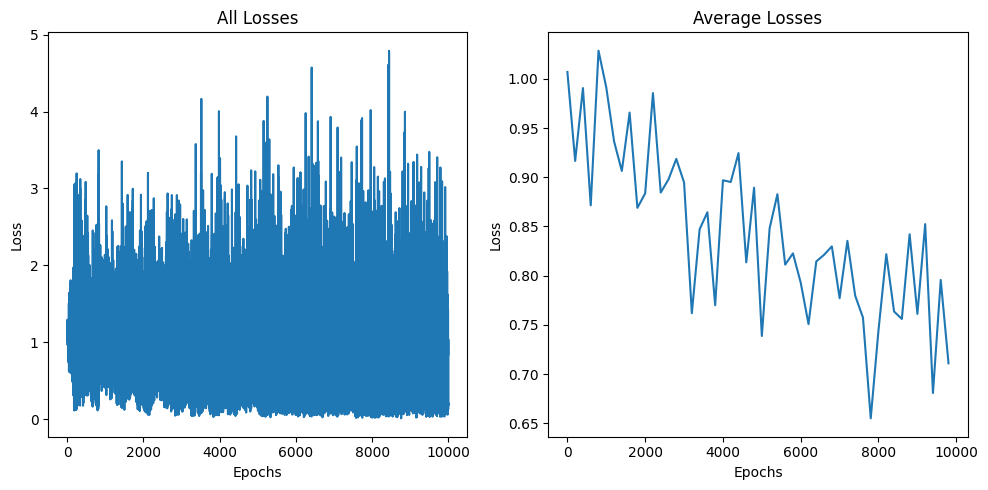

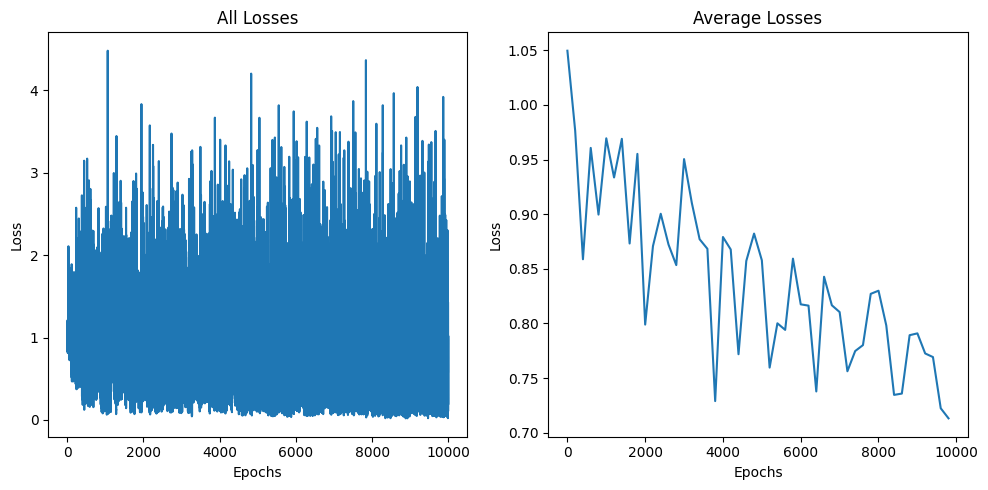

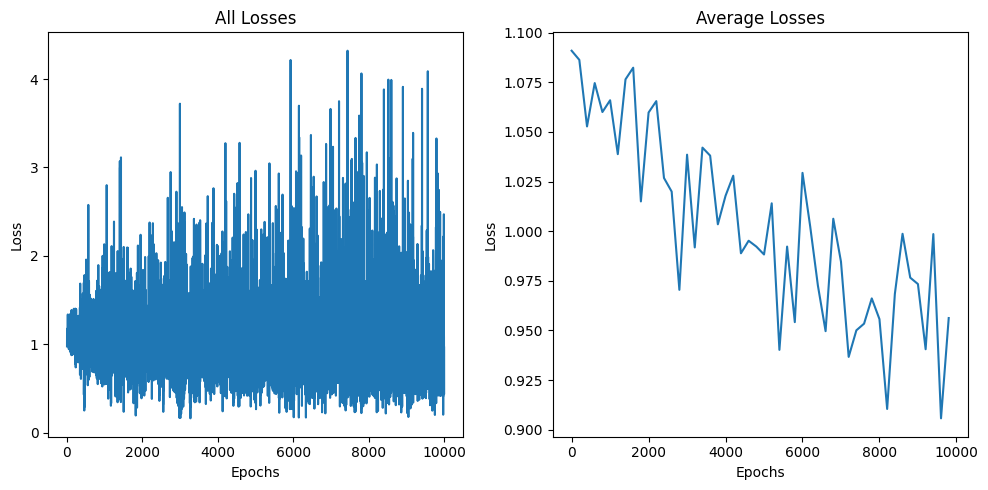

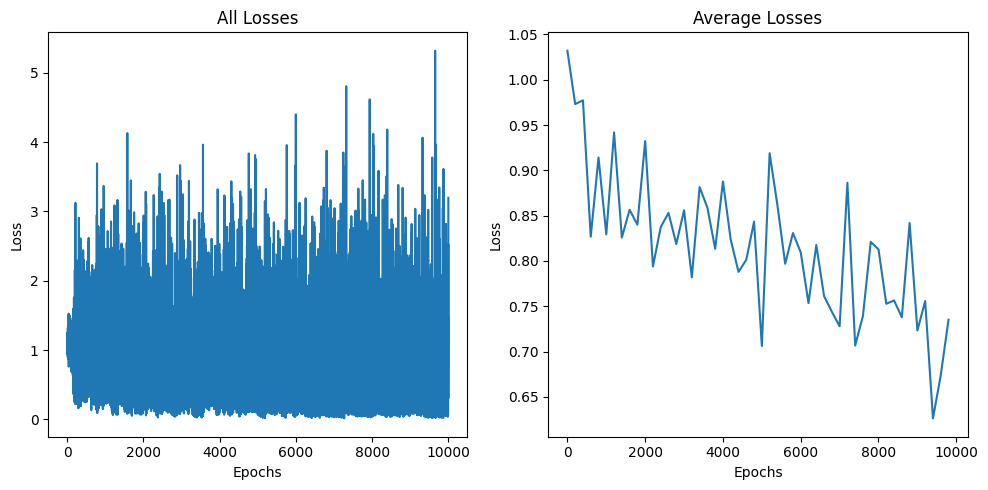

In [37]:
plot_graphs(num_epochs, plot_interval, plot_all_losses1, plot_avg_losses1)
plot_graphs(num_epochs, plot_interval, plot_all_losses2, plot_avg_losses2)
plot_graphs(num_epochs, plot_interval, plot_all_losses3, plot_avg_losses3)
plot_graphs(num_epochs, plot_interval, plot_all_losses4, plot_avg_losses4)

# 3. Testing and Evaluation

In [30]:
# Function to get model's prediction on test data
def predict(encoder, decoder, sentence, aspect, integration_type):
    with torch.no_grad():
        sent = preprocess_data([sentence])[0]
        sent_idx = [word_to_idx[word] for word in sent]
        aspect_idx = word_to_idx[aspect]
        no_sep_idx = combine_sentence_aspect(sent_idx, aspect_idx, has_sep=False)
        with_sep_idx = combine_sentence_aspect(sent_idx, aspect_idx, has_sep=True)
        aspect_tensor = torch.LongTensor([[aspect_idx]])
        
        if integration_type == NO_ASPECT:
            input_tensor = torch.LongTensor([[idx] for idx in sent_idx])
            encoder_hiddens = torch.zeros(MAX_LENGTH, encoder.hidden_size)
        elif integration_type == WITH_SEP:
            input_tensor = torch.LongTensor([[idx] for idx in with_sep_idx])
            encoder_hiddens = torch.zeros(MAX_COMBINED_LENGTH+1, encoder.hidden_size)
        elif integration_type == ASPECT_EMBED:
            input_tensor = torch.LongTensor([[idx] for idx in sent_idx])
            encoder_hiddens = torch.zeros(MAX_LENGTH, encoder.hidden_size)
        elif integration_type == NO_SEP:
            input_tensor = torch.LongTensor([[idx] for idx in no_sep_idx])
            encoder_hiddens = torch.zeros(MAX_COMBINED_LENGTH, encoder.hidden_size)

        input_length = input_tensor.size(0)
        encoder_hidden = encoder.init_hidden()
        encoder_cell = encoder.init_hidden()
        for ei in range(input_length):
            _, (encoder_hidden, encoder_cell) = encoder(input_tensor[ei], encoder_hidden, encoder_cell, aspect_tensor)
            encoder_hiddens[ei] = encoder_hidden[0, 0]
            
        y_output = decoder(encoder_hidden, encoder_hiddens)
        _, topi = y_output.topk(1)
        polarity = idx_to_polarity[topi[0].item()]
        return polarity

# Function to calculate model accuracy on test data
def evaluate(encoder, decoder, test_data, integration_type):
    correct = 0
    for i in range(len(test_data)):
        sentence = test_data[i]
        aspect = test_a[i]
        polarity = test_y[i]
        pred_polarity = predict(encoder, decoder, sentence, aspect, integration_type)
        if pred_polarity == polarity:
            correct += 1
    accuracy = correct / len(test_data)
    return accuracy

## Aspect embedding

In [36]:
# Get the accuracy of the model on test data
integration_type = ASPECT_EMBED
accuracy1 = evaluate(encoder1, decoder1, test_x, integration_type)
print(f"Accuracy: {accuracy1:.4f}")

Accuracy: 0.6215


## With separator

In [34]:
# Get the accuracy of the model on test data
integration_type = WITH_SEP
accuracy2 = evaluate(encoder2, decoder2, test_x, integration_type)
print(f"Accuracy: {accuracy2:.4f}")

Accuracy: 0.5916


## No aspect

In [31]:
# Get the accuracy of the model on test data
integration_type = NO_ASPECT
accuracy3 = evaluate(encoder3, decoder3, test_x, integration_type)
print(f"Accuracy: {accuracy3:.4f}")

Accuracy: 0.4661


## No separator

In [18]:
# Get the accuracy of the model on test data
integration_type = NO_SEP
accuracy4 = evaluate(encoder4, decoder4, test_x, integration_type)
print(f"Accuracy: {accuracy4:.4f}")

Accuracy: 0.6382
